In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble,plotting
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34081 instead
  warnings.warn(
/tmp/ipykernel_2096862/453806833.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/intermediate/'
pcastore = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g')
haiyan_data = read_and_proc.depickle(folderpath+'pca/flatvar'+'_'+'dict2_g')

In [16]:
np.max((np.sqrt(surfU_0**2+surfV_0**2)))

NameError: name 'surfU_0' is not defined

In [17]:
def _back_to_exp(timeseries=None,divider=None):
    printout = [timeseries[0:divider[0],:]]
    for i in range(1,19):
        printout.append(timeseries[divider[i-1]:divider[i],:])
    printout.append(timeseries[divider[-2]:,:])
    return printout

def get_surf_azim(index=None):
    surfU_0,surfV_0 = np.asarray(expU[index]).reshape(expU[index].shape[0],10,int(expU[index].shape[1]/10))[:,0,...],np.asarray(expV[index]).reshape(expV[index].shape[0],10,int(expV[index].shape[1]/10))[:,0,...]
    #surfU_1,surfV_1 = np.asarray(expU[1]).reshape(expU[1].shape[0],10,360,int(expU[1].shape[1]/10/360))[:,0,...],np.asarray(expV[1]).reshape(expV[1].shape[0],10,360,int(expV[1].shape[1]/10/360))[:,0,...]
    surWSPD_0 = np.max((np.sqrt(surfU_0**2+surfV_0**2)),axis=1)
    return surWSPD_0

RADtimeseries = pcastore['rad'].transform(haiyan_data['rad'].data)[:,0:10]
QVtimeseries = pcastore['qv'].transform(haiyan_data['qv'].data)[:,0:10]
PCRAD,PCQV = _back_to_exp(RADtimeseries[:,:],divider),_back_to_exp(QVtimeseries[:,:],divider)
expU,expV,expQV = _back_to_exp(haiyan_data['u'],divider),_back_to_exp(haiyan_data['v'],divider),_back_to_exp(haiyan_data['qv'],divider)
maxmeanWSURF = [get_surf_azim(index) for index in range(20)]

### Trajectory

In [29]:
import pandas as pd
unsorted_inten = pd.Series([np.max(np.gradient(maxmeanWSURF[i])) for i in range(20)])
sorted_inten = pd.Series([np.max(np.gradient(maxmeanWSURF[i])) for i in range(20)]).sort_values()

In [ ]:
import pandas as pd
inten_rate = [(maxmeanWSURF[i][np.abs(maxmeanWSURF[i]-33).argmin()]-maxmeanWSURF[i][0])/(np.abs(maxmeanWSURF[i]-33).argmin())*(60) for i in range(20)]
ds = pd.DataFrame({'inten_rate':inten_rate})

In [40]:
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))

ds = pd.DataFrame({'inten_rate':sorted_inten})
# Intensification Rates
slowinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate<1.4)].index)])
medinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>1.4) & (ds.inten_rate<1.6)].index)])
quickinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>1.6)].index)])
# PC2
slowPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate<1.4)].index)])
medPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>1.4) & (ds.inten_rate<1.6)].index)])
quickPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>1.6)].index)])
# PC6
slowPCQV = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate<1.4)].index)])
medPCQV = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate>1.4) & (ds.inten_rate<1.6)].index)])
quickPCQV = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate>1.6)].index)])

/tmp/ipykernel_2096862/227371349.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))


In [41]:
meanWSURF_slow,meanPC2_slow,meanPCQV_slow = np.nanmean(slowinten,axis=0),np.nanmean(slowPC2,axis=0),np.nanmean(slowPCQV,axis=0)
meanWSURF_med,meanPC2_med,meanPCQV_med = np.nanmean(medinten,axis=0),np.nanmean(medPC2,axis=0),np.nanmean(medPCQV,axis=0)
meanWSURF_quick,meanPC2_quick,meanPCQV_quick = np.nanmean(quickinten,axis=0),np.nanmean(quickPC2,axis=0),np.nanmean(quickPCQV,axis=0)

/tmp/ipykernel_2096862/3680970103.py:18: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


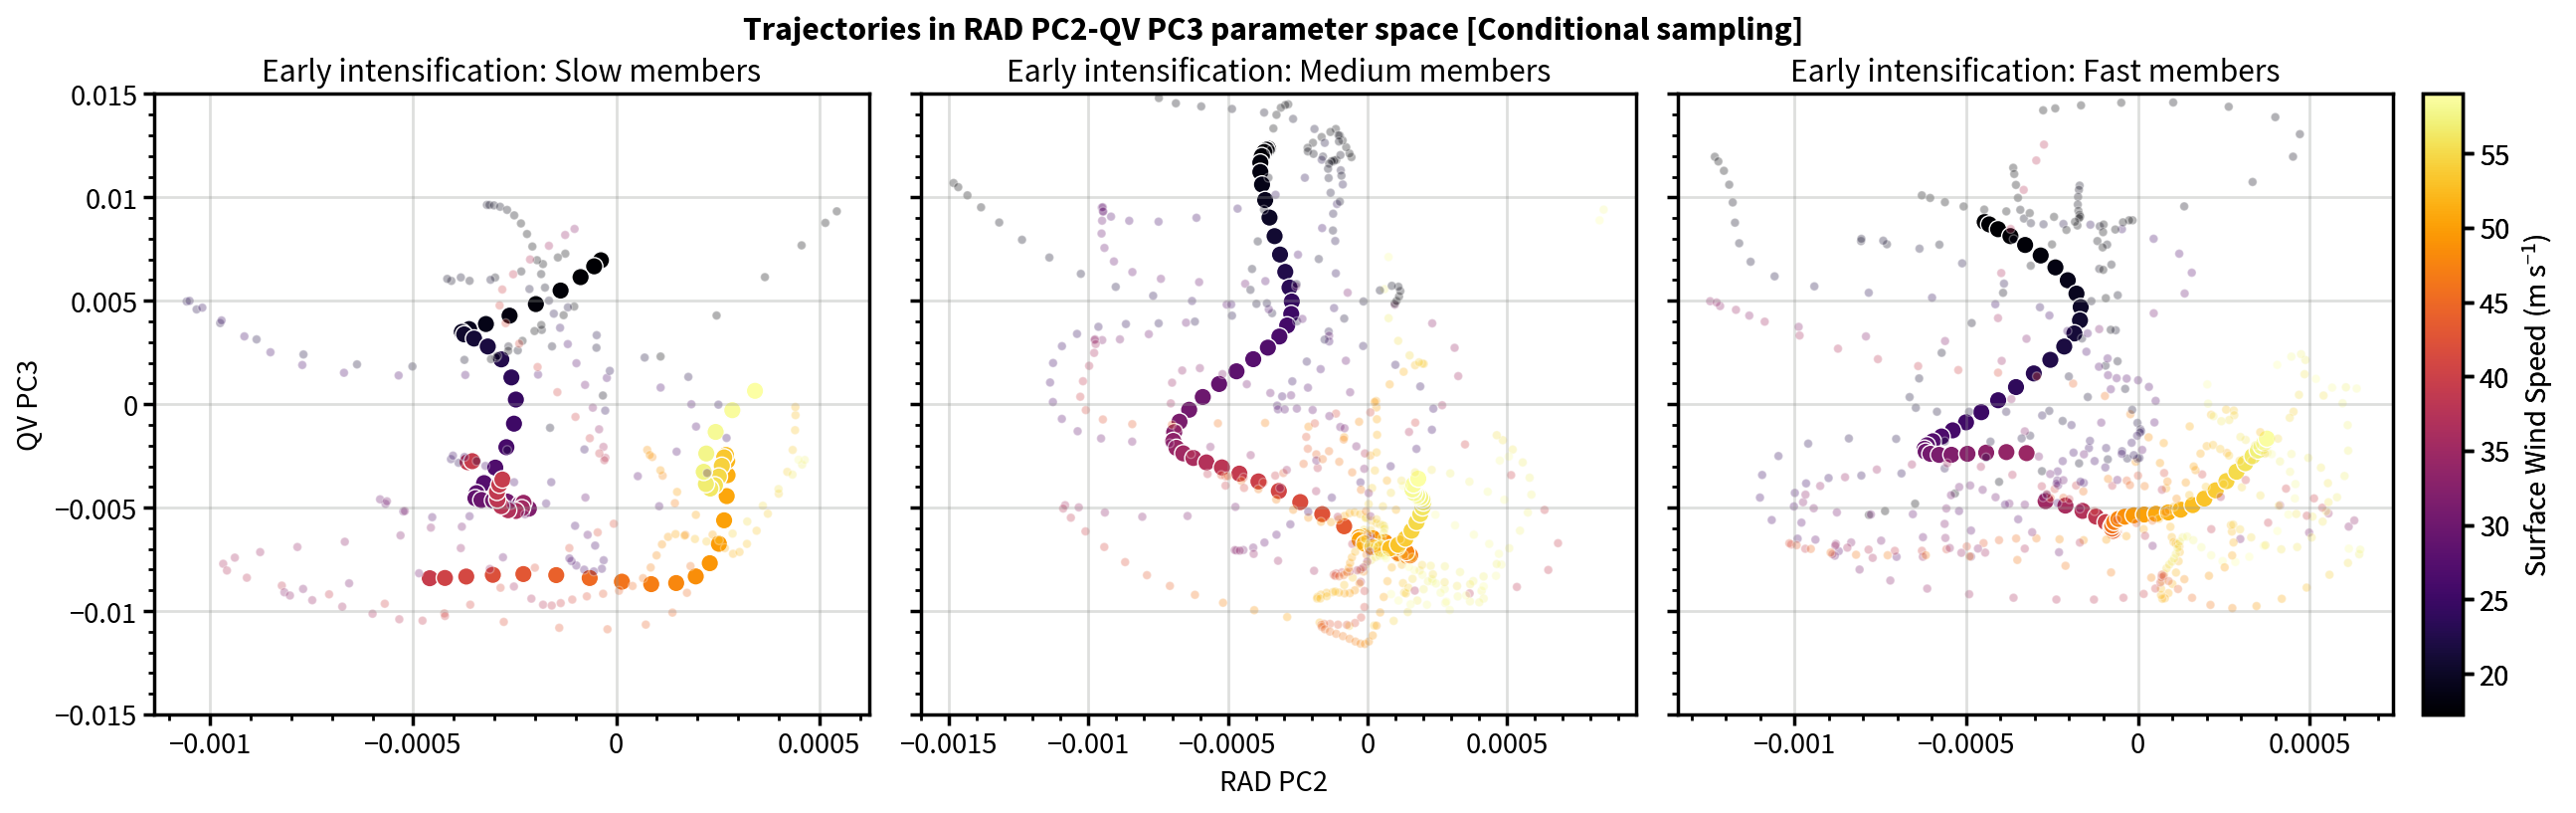

In [48]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].scatter(np.ma.masked_where(meanWSURF_slow>59,meanPC2_slow),np.ma.masked_where(meanWSURF_slow>59,meanPCQV_slow), 
                    s= 40, c = meanWSURF_slow, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(slowinten)):
    axs[0].scatter(np.ma.masked_where(slowinten[i]>59,slowPC2[i]),np.ma.masked_where(slowinten[i]>59,slowPCQV[i]), 
                   s= 10, c = slowinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
#index = 12
ct1 = axs[1].scatter(np.ma.masked_where(meanWSURF_med>59,meanPC2_med),np.ma.masked_where(meanWSURF_med>59,meanPCQV_med), 
                    s= 40, c = meanWSURF_med, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(medinten)):
    axs[1].scatter(np.ma.masked_where(medinten[i]>59,medPC2[i]),np.ma.masked_where(medinten[i]>59,medPCQV[i]), 
                   s= 10, c = medinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
ct2 = axs[2].scatter(np.ma.masked_where(meanWSURF_quick>59,meanPC2_quick),np.ma.masked_where(meanWSURF_quick>59,meanPCQV_quick), 
                    s= 40, c = meanWSURF_quick, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59)
for i in range(len(quickinten)):
    axs[2].scatter(np.ma.masked_where(quickinten[i]>59,quickPC2[i]),np.ma.masked_where(quickinten[i]>59,quickPCQV[i]), 
                   s= 10, c = quickinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='Surface Wind Speed (m s$^{-1}$)')
axs.format(ylabel='QV PC3',xlabel='RAD PC2',suptitle=r'Trajectories in RAD PC2-QV PC3 parameter space [Conditional sampling]',ylim=[-0.015,0.015])
axs[0].format(title=r'Early intensification: Slow members')
axs[1].format(title=r'Early intensification: Medium members')
axs[2].format(title=r'Early intensification: Fast members')
plt.savefig('../../../figures/0727/intermediate_RADPC_QVPC_traj.png',dpi=300)
plt.show()

/tmp/ipykernel_2096862/2271355656.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


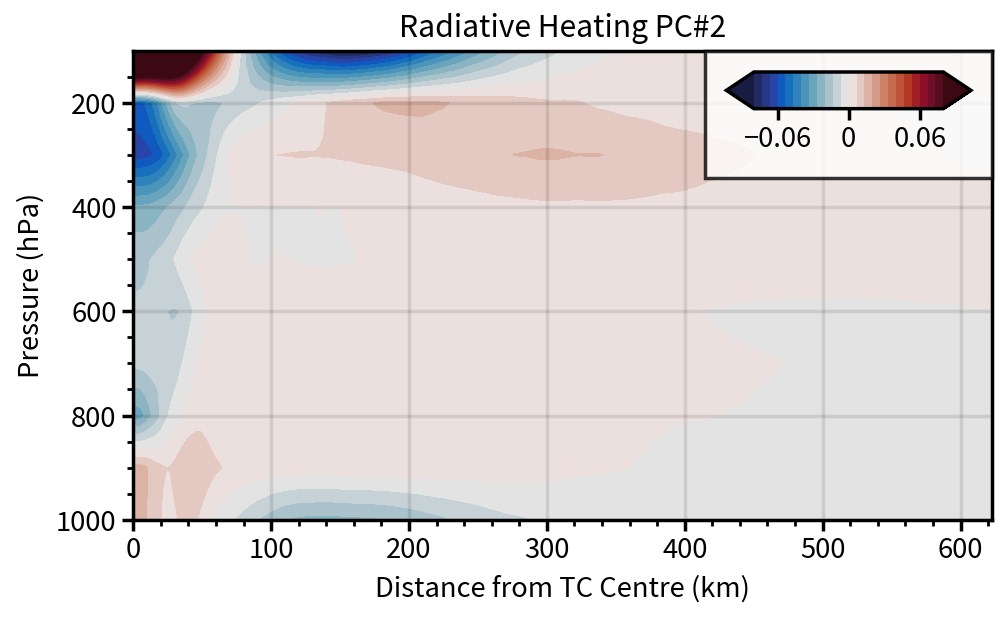

In [44]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs.contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),pcastore['rad'].components_[1,...].reshape(10,208),levels=np.linspace(-0.08,0.08,25),cmap='balance',extend='both')
axs.colorbar(pcw,loc='ur',ticks=0.06)
axs.format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Radiative Heating PC#2')
plt.savefig('../../../figures/0727/intermediate_RAD2.png',dpi=300)
plt.show()

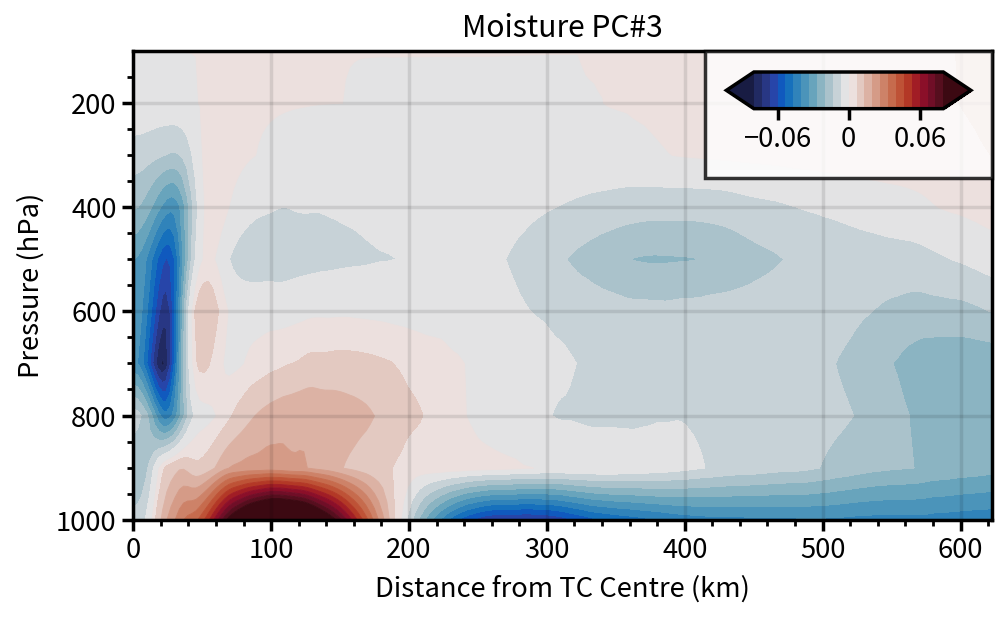

In [47]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs.contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),pcastore['qv'].components_[2,...].reshape(10,208),levels=np.linspace(-0.08,0.08,25),cmap='balance',extend='both')
axs.colorbar(pcw,loc='ur',ticks=0.06)
axs.format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Moisture PC#3')
plt.savefig('../../../figures/0727/intermediate_nonRAD1.png',dpi=300)
plt.show()